In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random

2023-07-02 13:40:40.784153: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-02 13:40:41.011833: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-02 13:40:41.395726: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-02 13:40:41.398486: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 13:40:44.287093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Load the data

In [2]:
!mkdir data && wget https://github.com/sdip15fa/weather-predict/raw/master/data/processed_data.csv -O data/processed_data.csv
!if ! [ -f "lstm.keras" ]; then wget https://github.com/sdip15fa/weather-predict/raw/master/lstm.keras; fi;

input_file = 'data/processed_data.csv'
df = pd.read_csv('data/processed_data.csv',
                 parse_dates=['DateTime'], index_col='DateTime')
df = df.resample('60T').mean()
# df["DateTime"] = pd.to_datetime(df.index)
df = df.reset_index()

mkdir: cannot create directory ‘data’: File exists


In [3]:
time_steps = 72  # Number of time steps for the LSTM model

In [4]:
features_keys = ['Temperature', 'Wind Speed',
               'Rainfall', 'Humidity']

Convert the 'Date' and 'Time' columns to integers

In [5]:
df["Temperature"] = df["Temperature"].astype(float)
df["Wind Speed"] = df["Wind Speed"].astype(float)
df["Rainfall"] = df["Rainfall"].astype(float)
df["Wind Direction"] = df["Wind Direction"].astype(float)
df["Humidity"] = df["Humidity"].astype(float)

Filter and replace outliers

In [6]:
df['Temperature'] = df['Temperature'].replace(3276.7, np.nan)
df['Wind Speed'] = df['Wind Speed'].replace(32767, np.nan)
df['Rainfall'] = df['Rainfall'].replace(32767, np.nan)
df['Wind Direction'] = df['Wind Direction'].replace(32767, np.nan)
df['Humidity'] = df['Humidity'].replace(32767, np.nan)
df['Temperature'] = df['Temperature'].mask((df['Temperature'] > 40) | (df['Temperature'] < -10), np.nan)
df['Wind Speed'] = df['Wind Speed'].mask((df['Wind Speed'] > 200) | df["Wind Speed"] < 0, np.nan)
df['Rainfall'] = df['Rainfall'].mask((df['Rainfall'] > 500)| df["Rainfall"] < 0, np.nan)
df['Wind Direction'] = df['Wind Direction'].mask((df['Wind Direction'] < 0) | (df['Wind Direction'] > 360), np.nan)
df['Humidity'] = df['Humidity'].mask((df['Humidity'] < 0) | (df['Humidity'] > 100), np.nan)
df['Temperature'] = df['Temperature'].fillna(df['Temperature'].mean())
df['Wind Speed'] = df['Wind Speed'].fillna(df['Wind Speed'].mean())
df['Rainfall'] = df['Rainfall'].fillna(df['Rainfall'].mean())
df['Wind Direction'] = df['Wind Direction'].fillna(df['Wind Direction'].mean())
df['Humidity'] = df['Humidity'].fillna(df['Humidity'].mean())

In [7]:
df[df.isna().any(axis=1)]

,DateTime,Year,Month,Date,Time,Minute,Temperature,Wind Speed,Wind Direction,Rainfall,Humidity
36,2008-01-02 12:00:00,2008.0,1.0,2.0,12.0,1.0,NaN,NaN,NaN,NaN,NaN
38,2008-01-02 14:00:00,2008.0,1.0,2.0,14.0,1.0,11.2,19.0,NaN,0.0,27.0
39,2008-01-02 15:00:00,2008.0,1.0,2.0,15.0,1.0,10.7,13.0,NaN,0.0,31.0
59,2008-01-03 11:00:00,2008.0,1.0,3.0,11.0,1.0,11.9,15.0,NaN,0.0,36.0
111,2008-01-05 15:00:00,2008.0,1.0,5.0,15.0,1.0,16.0,10.0,NaN,0.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...
126923,2022-06-24 11:00:00,2022.0,6.0,24.0,11.0,1.0,25.6,7.0,209.0,0.0,NaN
126924,2022-06-24 12:00:00,2022.0,6.0,24.0,12.0,1.0,25.6,22.0,198.0,0.0,NaN
126925,2022-06-24 13:00:00,2022.0,6.0,24.0,13.0,1.0,24.8,13.0,189.0,0.0,NaN
126926,2022-06-24 14:00:00,2022.0,6.0,24.0,14.0,1.0,25.7,28.0,200.0,0.0,NaN


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale the data to [0, 1]

Scale the temperature, wind speed, rainfall, and wind direction values

In [9]:
features = df[features_keys].copy()
scaled_features = scaler.fit_transform(features.dropna())

In [10]:
scaled_features

array([[0.19047619, 0.27365729, 0.        , 0.34375   ],
       [0.17142857, 0.26342711, 0.        , 0.32291667],
       [0.14920635, 0.25831202, 0.        , 0.34375   ],
       ...,
       [0.78730159, 0.28900256, 0.        , 1.        ],
       [0.78730159, 0.30946292, 0.        , 1.        ],
       [0.78412698, 0.25063939, 0.00555556, 1.        ]])

Fill NaN values by predicting

In [11]:
"""
pretrained_model: tf.keras.Model = None
try:
    pretrained_model = tf.keras.models.load_model("lstm.keras")
except:
    pass

if pretrained_model:
    for col in features_keys:
        indices = df[df[col].isna() == True].index.values
        # while len(indices) > 0 and len(list(filter(lambda x: x > time_steps, indices))):
        input_data = []
        for i in indices:
                input_data_i = df[features_keys].iloc[i-time_steps-1:i-1]
                if len(input_data_i): # and not len(input_data_i[input_data_i[col].isna() == True]):
                    input_data_i = scaler.transform(input_data_i)
                    input_data.append(input_data_i)
                else:
                    indices = np.setdiff1d(indices, i)
        if len(input_data):
                input_data = np.array(input_data).reshape(
                    len(input_data), time_steps, len(features_keys))
                predicted = pd.DataFrame(scaler.inverse_transform(pretrained_model.predict(
                    input_data)), columns=features_keys, index=indices)[col].values
                df.loc[indices, col] = predicted
        indices = df[df[col].isna() == True].index.values
"""

2023-07-02 13:40:49.475166: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1579] failed to query PCI bus id for device: UNKNOWN ERROR (801)
2023-07-02 13:40:49.475272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:970] no PCI bus ID for device ordinal: 0
2023-07-02 13:40:49.476229: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2023-07-02 13:40:51.197685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-02 13:40:51.203698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-02 13:40:51.208451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

121/121 [==============================] - 11s 91ms/step


In [12]:
df = df.fillna(method="ffill").fillna(method="bfill")

Prepare the data for LSTM

Remove rows with missing values

In [13]:
df = df.dropna().reset_index()

In [14]:
df

,index,DateTime,Year,Month,Date,Time,Minute,Temperature,Wind Speed,Wind Direction,Rainfall,Humidity
0,0,2008-01-01 00:00:00,2008.0,1.0,1.0,0.0,1.0,3.6,107.0,49.0,0.0,37.0
1,1,2008-01-01 01:00:00,2008.0,1.0,1.0,1.0,1.0,3.0,103.0,42.0,0.0,35.0
2,2,2008-01-01 02:00:00,2008.0,1.0,1.0,2.0,1.0,2.3,101.0,39.0,0.0,37.0
3,3,2008-01-01 03:00:00,2008.0,1.0,1.0,3.0,1.0,2.4,92.0,47.0,0.0,33.0
4,4,2008-01-01 04:00:00,2008.0,1.0,1.0,4.0,1.0,2.0,102.0,47.0,0.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...
127144,127144,2022-07-03 16:00:00,2022.0,7.0,3.0,16.0,1.0,22.5,135.0,201.0,0.0,100.0
127145,127145,2022-07-03 17:00:00,2022.0,7.0,3.0,17.0,1.0,22.5,131.0,192.0,0.0,100.0
127146,127146,2022-07-03 18:00:00,2022.0,7.0,3.0,18.0,1.0,22.4,113.0,195.0,0.0,100.0
127147,127147,2022-07-03 19:00:00,2022.0,7.0,3.0,19.0,1.0,22.4,121.0,196.0,0.0,100.0


Check if any hours are missing

In [15]:
"""
# Get the minimum and maximum DateTime values in the DataFrame
min_time = df['DateTime'].min()
max_time = df['DateTime'].max()

# Create a complete sequence of hours using pandas date_range
complete_hours = pd.date_range(start=min_time, end=max_time, freq='H')

# Extract the unique hours from the DataFrame
existing_hours = pd.to_datetime(df['DateTime']).unique()

# Find the missing hours by comparing the complete sequence with the existing hours
missing_hours = [hour for hour in complete_hours if hour not in existing_hours]

# Print the missing hours
print(missing_hours)
"""

"\n# Get the minimum and maximum DateTime values in the DataFrame\nmin_time = df['DateTime'].min()\nmax_time = df['DateTime'].max()\n\n# Create a complete sequence of hours using pandas date_range\ncomplete_hours = pd.date_range(start=min_time, end=max_time, freq='H')\n\n# Extract the unique hours from the DataFrame\nexisting_hours = pd.to_datetime(df['DateTime']).unique()\n\n# Find the missing hours by comparing the complete sequence with the existing hours\nmissing_hours = [hour for hour in complete_hours if hour not in existing_hours]\n\n# Print the missing hours\nprint(missing_hours)\n"

Create sequences of input data and corresponding target values

In [16]:
data = []
target = []
for i in range(1, len(scaled_features) - time_steps):
    # exclude the target
    data.append(scaled_features[i:i+time_steps])
    # Only the temperature is the target
    target.append(scaled_features[i+time_steps])

In [17]:
data = np.array(data)
target = np.array(target)


Split the dataset into training and validation sets

In [18]:
split = 0.1
random_state = 42

random.seed(random_state)
np.random.seed(random_state)

val_index = (pd.Series([random.random() for _ in range(len(target))]) < split).values

train_data, train_target = data[~val_index], target[~val_index]
val_data, val_target = data[val_index], target[val_index]

Build the LSTM model architecture

In [98]:
import tensorflow as tf
"""
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True,
                         input_shape=(time_steps, 4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
"""
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(512,  input_shape=(time_steps, len(features_keys))),
    # tf.keras.layers.LSTM(128, return_sequences=True),
    # tf.keras.layers.LSTM(64),
    # tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.LSTM(32, return_sequences=True),
    # tf.keras.layers.LSTM(128, return_sequences=True),
    # tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.LSTM(64),
    # tf.keras.layers.Dense(64),
    # tf.keras.layers.Dense(64),
    # tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(len(features_keys))
])


Compile the model

In [99]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', optimizer=optimizer)

Define early stopping and learning rate scheduler

In [100]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

Train the LSTM model

In [101]:
batch_size = 4096
epochs = 50
history = model.fit(train_data, train_target, batch_size=batch_size, epochs=epochs, validation_data=(val_data, val_target),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
28/28 [==============================] - 13s 393ms/step - loss: 0.1705 - val_loss: 0.0697 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 11s 378ms/step - loss: 0.0574 - val_loss: 0.0448 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 11s 380ms/step - loss: 0.0415 - val_loss: 0.0365 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 11s 381ms/step - loss: 0.0366 - val_loss: 0.0346 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 11s 379ms/step - loss: 0.0346 - val_loss: 0.0313 - lr: 0.0010
Epoch 6/50
28/28 [==============================] - 11s 376ms/step - loss: 0.0309 - val_loss: 0.0306 - lr: 0.0010
Epoch 7/50
28/28 [==============================] - 11s 380ms/step - loss: 0.0302 - val_loss: 0.0299 - lr: 0.0010
Epoch 8/50
28/28 [==============================] - 11s 383ms/step - loss: 0.0284 - val_loss: 0.0319 - lr: 0.0010
Epoch 9/50
28/28 [==============================] - 11s 383ms/step - loss: 0.0314 - val_

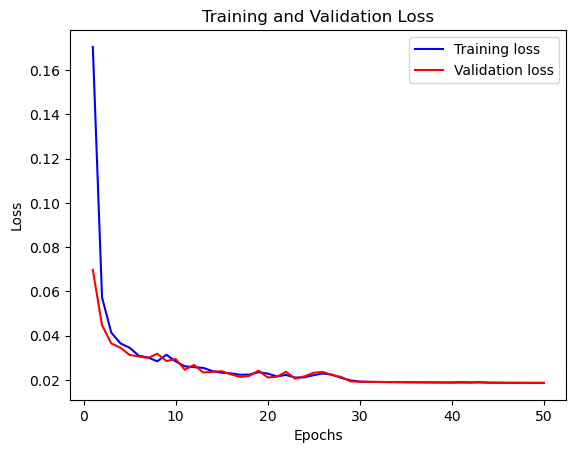

In [102]:
# Access the loss values from the training history
train_losses = history.history['loss']
val_losses = history.history['val_loss']

# Plot the loss values
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Make predictions using the trained LSTM model

In [103]:
predictions = model.predict(val_data)

397/397 [==============================] - 2s 4ms/step


Rescale the predictions back to the original range

In [104]:
scaled_predictions = pd.DataFrame(predictions, columns=features_keys)
predictions = pd.DataFrame(scaler.inverse_transform(
    predictions), columns=features_keys)
predicted_temperature = predictions["Temperature"]


In [105]:
val_target = pd.DataFrame(val_target, columns=features_keys)
val_target_rescaled = pd.DataFrame(scaler.inverse_transform(val_target), columns=features_keys)
train_target = pd.DataFrame(train_target, columns=features_keys)
train_target_rescaled = pd.DataFrame(scaler.inverse_transform(train_target), columns=features_keys)

Calculate MSE and MAE

In [106]:
mse = mean_squared_error(val_target_rescaled["Temperature"], predictions["Temperature"])
mae = mean_absolute_error(val_target_rescaled["Temperature"], predictions["Temperature"])

In [107]:
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.49564062792269736
Mean Absolute Error (MAE): 0.46884516722047287


Visualize the actual vs. predicted temperatures for the validation set

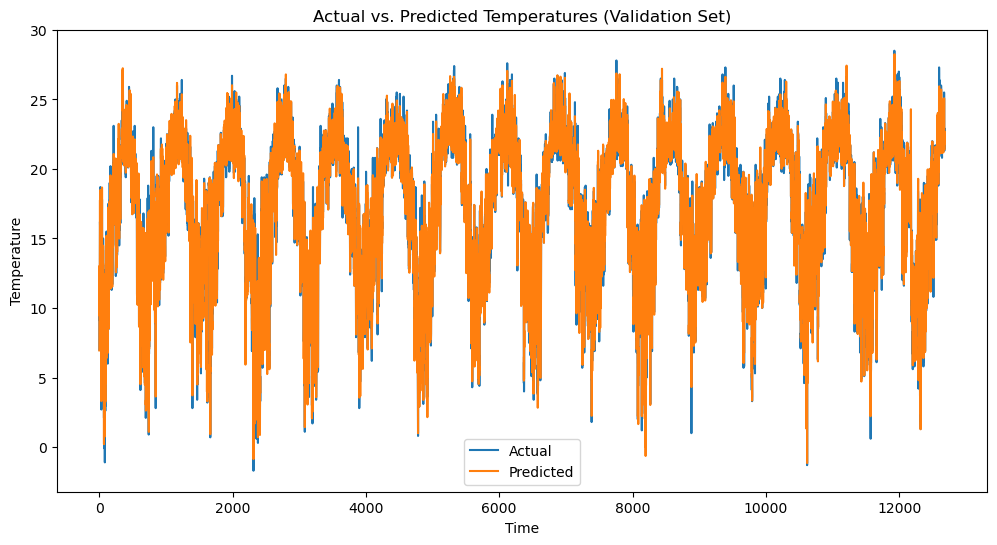

In [108]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(val_target)), val_target_rescaled["Temperature"], label='Actual')
plt.plot(range(len(val_target)), predicted_temperature, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Temperatures (Validation Set)')
plt.legend()
plt.show()

Visualize the actual vs. predicted temperatures for the training set

3535/3535 [==============================] - 16s 4ms/step


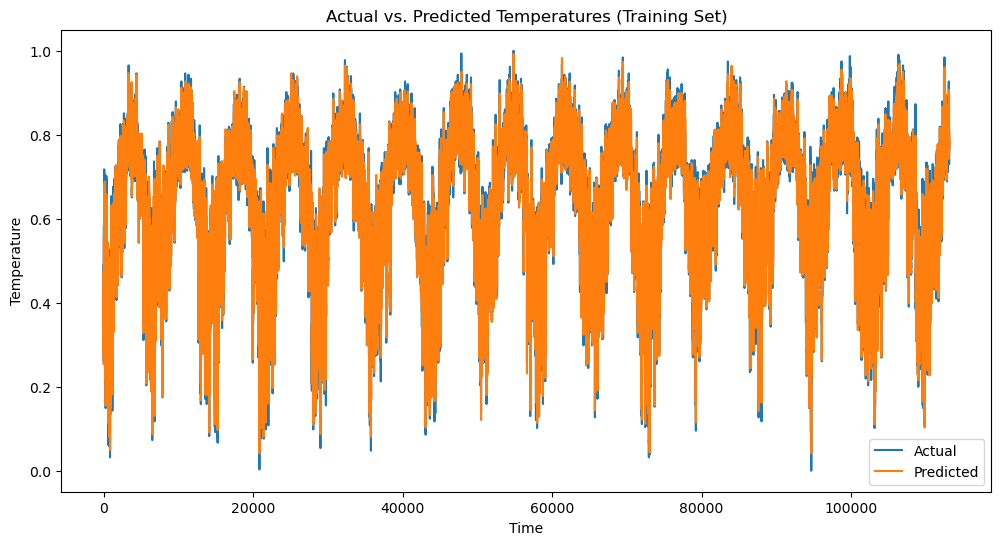

In [109]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_target)), train_target["Temperature"], label='Actual')
plt.plot(range(len(train_target)), pd.DataFrame(model.predict(
    train_data), columns=features_keys)["Temperature"], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Temperatures (Training Set)')
plt.legend()
plt.show()

Save the trained model

In [110]:
model.save("lstm.keras")

In [25]:
from datetime import timedelta
model = tf.keras.models.load_model("lstm.keras")

data = scaled_features.copy()[-time_steps:]
predicted = []

predict_steps = 30

for i in range(1, predict_steps + 1):
    scaled_prediction = model.predict(data.reshape(1, time_steps, len(features_keys)))
    prediction = scaler.inverse_transform(scaled_prediction)[0]
    print(f'{df["DateTime"].max() + timedelta(hours=i)}:', list(map(lambda x: round(x, 6), prediction)))
    # print(prediction[0], data, np.append(data, prediction[0]))
    data = np.vstack((data, scaled_prediction))
    data = np.delete(data, 0, axis=0)
    predicted.append(prediction)

2023-07-02 13:47:03.811367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-02 13:47:03.815116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-02 13:47:03.817996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 789ms/step
2022-07-03 21:00:00: [22.423735, 98.75884, 0.661935, 100.04327]
1/1 [==============================] - 0s 93ms/step
2022-07-03 22:00:00: [22.462507, 97.678, 0.358436, 99.9738]
1/1 [==============================] - 0s 68ms/step
2022-07-03 23:00:00: [22.529097, 96.827034, 0.176441, 99.93908]
1/1 [==============================] - 0s 72ms/step
2022-07-04 00:00:00: [22.599125, 95.928566, 0.06011, 99.935745]
1/1 [==============================] - 0s 69ms/step
2022-07-04 01:00:00: [22.664219, 94.99028, -0.003719, 99.94052]
1/1 [==============================] - 0s 88ms/step
2022-07-04 02:00:00: [22.716812, 94.08426, -0.031743, 99.93839]
1/1 [==============================] - 0s 79ms/step
2022-07-04 03:00:00: [22.752186, 93.275406, -0.038646, 99.92746]
1/1 [==============================] - 0s 77ms/step
2022-07-04 04:00:00: [22.765768, 92.61195, -0.033811, 99.91257]
1/1 [==============================] - 0s 82ms/step
2022-07-04 05:00:00: [

In [26]:
results = pd.DataFrame(predicted, columns=features_keys)
results.insert(0, "DateTime", [df["DateTime"].max() + timedelta(hours=i) for i in range(1, predict_steps + 1)])
results.to_csv("predict.csv")

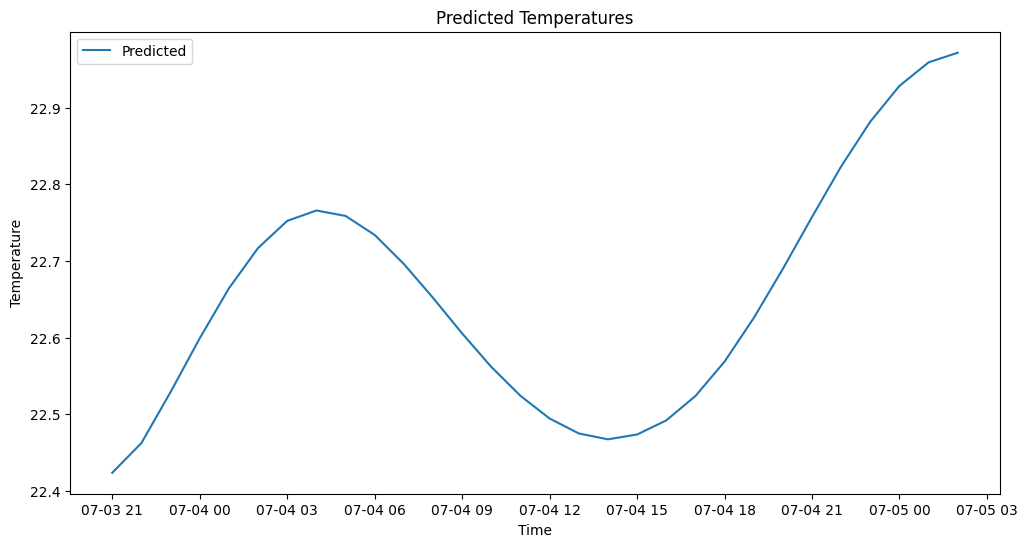

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(results["DateTime"], np.array(predicted)[:, 0], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Predicted Temperatures')
plt.legend()
plt.show()